In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/merge.py:18: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/dataarray.py:1829: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  'DataArray', pd.Series, pd.DataFrame, pd.Panel]:


In [2]:
from matplotlib import rc

labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)
rc('patch', linewidth=linewidth)

In [3]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)
cell_tidy_data.index.name = 'cell'

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/dissection_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

cell_class_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/cell_class.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

for sub_type in cell_tidy_data['SubType'].unique():
    if sub_type not in sub_type_palette:
        # outlier and NA color
        sub_type_palette[sub_type] = '#D3D3D3'

In [5]:
mcds = xr.open_dataset(
    '/home/hanliu/project/mouse_rostral_brain/study/mCClustermCLevel/SubType.geneslop2k.mcds'
)['gene_cluster_da_rate'].sel(mc_type='CHN')
gene_df = mcds.to_pandas()

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/dataarray.py:1849: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  3: pd.Panel}


In [6]:
gene_meta = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusterMethylMarker/gencode.vM22.annotation.gene.flat.filtered_white_genes.tsv.gz',
    index_col='gene_id',
    sep='\t')
gene_meta.index.name = 'gene'
gene_name_to_id = {v: k for k, v in gene_meta['gene_name'].iteritems()}
gene_idbase_to_id = {i.split('.')[0]: i for i in gene_meta.index}

In [7]:
pairwise_marker = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusterMethylMarker/SubTypePairwiseDEG/TotalGeneID.txt',
    index_col=0, header=None
).index

gene_df = gene_df[pairwise_marker]

In [8]:
subtype_order = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/order/SubType.order.txt',
                            header=None, index_col=0).index
subtype_order = subtype_order & pd.Index(cell_tidy_data[cell_tidy_data['CellClass'] != 'NonN']['SubType'].unique())
gene_df = gene_df.reindex(subtype_order)

In [9]:
gene_df.fillna(0, inplace=True)
gene_df.isna().sum(axis=0).describe()

count    27194.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
dtype: float64

In [10]:
gene_df.shape

(145, 27194)

In [11]:
from sklearn.metrics import pairwise_distances
from ALLCools.plot.color import plot_colorbar, plot_color_legend


In [12]:
cluster_corr = gene_df.T.corr()

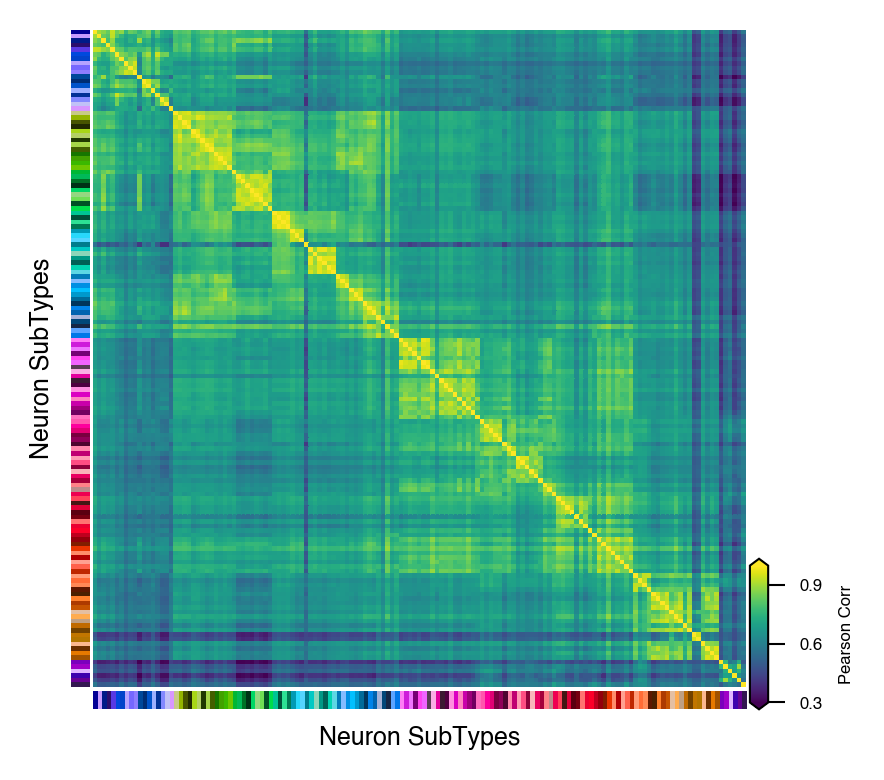

In [13]:
fig = plt.figure(figsize=(3, 3), dpi=300)

gs = fig.add_gridspec(31, 32)

ax = fig.add_subplot(gs[:-1, 1:-1])
ax_row = fig.add_subplot(gs[-1, 1:-1])
ax_col = fig.add_subplot(gs[:-1, 0])
cax = fig.add_subplot(gs[-7:, -1])

sns.heatmap(ax=ax, 
            data=cluster_corr.loc[subtype_order, subtype_order], 
            cbar=False, vmin=0.3, vmax=1, cmap='viridis')
ax.set(xticks=[], yticks=[], ylabel='', xlabel='')

plot_color_legend(sub_type_palette, ax=ax_row, order=subtype_order)
plot_color_legend(sub_type_palette, ax=ax_col, order=subtype_order, transpose=True)
ax_row.set(xticks=[], yticks=[], xlabel='Neuron SubTypes')
ax_col.set(xticks=[], yticks=[], ylabel='Neuron SubTypes')
sns.despine(ax=ax_row, left=True, bottom=True)
sns.despine(ax=ax_col, left=True, bottom=True)

plot_colorbar(cax=cax, cmap='viridis', hue_norm=(0.3, 1), label='Pearson Corr')
fig.savefig('Subtype.mCH.gene.corr.heatmap.pdf')